<h2>Forecasting</h2>

In this module, we discuss the forecasting task. This is a special case of the regression task - the prediction target (label) is numeric, however, we also have the time correlation among the instances in the data. The data for this task is usually referred to as time series data.

<h3> One-Dimensional Time Series</h3>

These are data with only one column (and possibly some time columns). While they are not that different from higher dimensional sequential data, we start with one dimension for simplicity.

For this task, we use the the daily minimum temperature data. This data consists of the daily minimum temperatures from 1981 to 1990 and only has two columns, Date and Temp. The task is to use current/historical data at a date to predict next day's temperature. 

<h4> Loading and Visualizing Data </h4>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
dailytemp = pd.read_csv('daily-min-temperatures.csv')
dailytemp['Date'] = pd.to_datetime(dailytemp['Date']) #date will be read in as string, so we manually convert it to pandas date
dailytemp

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


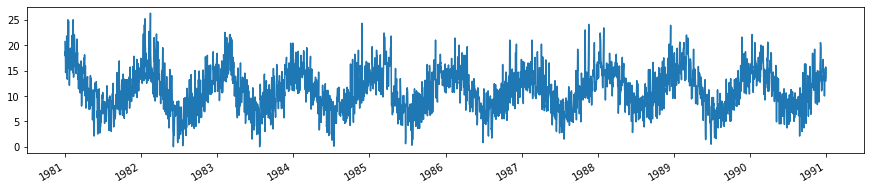

In [4]:
plt.figure(figsize=(15,3))
plt.plot(dailytemp['Date'], dailytemp['Temp'])
plt.gcf().autofmt_xdate()
plt.show()

<h4>Using with Regular Regression Models</h4>

Regular regression models like SVM, decision tree, random forest, while not having been designed specifically for data with time correlations, can still be applied to this task. However, we need to manually process the data to the desired format before being able to use them.

<h5>Obtaining Historical Data</h5>

In general, we can obtain historical data by having a moving window, for example, 5. Then, for each day, we use its temparature and the previous four as features.

Note that for any window size, we will need to remove the first window rows in the data as they do not have enough historical data.

Let's investigate the case with window=5. In this case, the 6th row will have enough historical data of 5 days before it, but the 1st-5th do not

In [8]:
dailytemp.loc[:5,:]

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8


So the historical data for 6th day will be

|Date|Temp|Temp (t-1)|Temp (t-2)|Temp (t-3)|Temp (t-4)|Temp (t-5)|
|----|----|----------|----------|----------|----------|----------|
|1981-01-06	|15.8|15.8|14.6|18.8|17.9|20.7|

This is also called **lagged** data. In this case, lag=window=5. The same transformation will go for the rest of the rows. 

The lagged data is only the feature part. We still need targets. As the target in the forecasting task we discuss in this class is always next time point, we do a similar shift, but ahead from the current time. So, for the 6th day, lagged data is temparature day 1 - 6, and target is temparature of day 7

In [26]:
dailytemp.loc[:6,:]

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8


|Date|Temp|Temp (t-1)|Temp (t-2)|Temp (t-3)|Temp (t-4)|Temp (t-5)|Temp (next)|
|----|----|----------|----------|----------|----------|----------|-----------|
|1981-01-06	|15.8|15.8|14.6|18.8|17.9|20.7|15.8|

We will utilize the shift function in pandas to create a dataset of lagged data and next-day target.

The function below is reusable for any sequential data with any window size, assuming there is one column for timestamp. You need to input the dataframe, window, and the timecolumn (if available)

In [125]:
def gen_hist_data(data,window,target,timecol=None):
    if timecol is None:
        lag_data = pd.concat([data.shift(t).add_suffix(f" (t-{t})") for t in range(window+1)], axis=1)
    else:
        time_data = data[timecol]
        lag_data = pd.concat([time_data]+[data.drop(timecol,axis=1).shift(t).add_suffix(f" (t-{t})") 
                                          for t in range(window+1)], axis=1)
    lag_data = pd.concat([lag_data, data[[target]].shift(-1).add_suffix(" (next)")], axis=1)
    return lag_data.iloc[window:-1,:]

example: window = 5

In [126]:
dailytemp5 = gen_hist_data(dailytemp, 5, 'Temp', 'Date')
dailytemp5

,Date,Temp (t-0),Temp (t-1),Temp (t-2),Temp (t-3),Temp (t-4),Temp (t-5),Temp (next)
5,1981-01-06,15.8,15.8,14.6,18.8,17.9,20.7,15.8
6,1981-01-07,15.8,15.8,15.8,14.6,18.8,17.9,17.4
7,1981-01-08,17.4,15.8,15.8,15.8,14.6,18.8,21.8
8,1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,20.0
9,1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,16.2
...,...,...,...,...,...,...,...,...
3644,1990-12-26,14.6,12.9,10.0,13.9,13.2,13.1,14.0
3645,1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.6
3646,1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.5
3647,1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,15.7


example: window = 10

In [127]:
dailytemp10 = gen_hist_data(dailytemp, 10, 'Temp', 'Date')
dailytemp10

,Date,Temp (t-0),Temp (t-1),Temp (t-2),Temp (t-3),Temp (t-4),Temp (t-5),Temp (t-6),Temp (t-7),Temp (t-8),Temp (t-9),Temp (t-10),Temp (next)
10,1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7,13.3
11,1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,16.7
12,1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,21.5
13,1981-01-14,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,25.0
14,1981-01-15,25.0,21.5,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,20.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3644,1990-12-26,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.9,13.6,14.0
3645,1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.9,13.6
3646,1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2,13.5
3647,1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,15.7


I will use the data with lag=5 to continue. Next, we split data into training, validation, and testing data. Since this is time correlated data, we will select a time point to split the train and test. In this case, I will use data before 1990 for training and data in 1990 for testing. 

The below function will split a time series dataset into train and test, as well as split the target from the features. You need to define the input data, time point to split, the target name, and the time column (if any)
- With a timecol, the split time should be a string in similar format to the time column
- Without a time col, the split time should be the index of the time to split
- Similarly like before, this function is reusable in general

In order, the function will output training features, testing features, training label, testing label

In [54]:
def split_seq_data(data,split,target,timecol=None):
    if timecol is None:
        trainX = data.drop(target, axis=1).loc[:split,:]
        testX = data.drop(target, axis=1).loc[split:,:]
        trainY = data[target][:split]
        testY = data[target][split:]
    else:
        trainX = data.drop([target,timecol], axis=1).loc[data[timecol] < split, :]
        testX = data.drop([target,timecol], axis=1).loc[data[timecol] >= split, :]
        trainY = data[target][data[timecol] < split]
        testY = data[target][data[timecol]>= split]
    return trainX, testX, trainY, testY

In [69]:
trainX, testX, trainY, testY = split_seq_data(dailytemp5, '1990-01-01', 'Temp (next)', 'Date')

In [56]:
trainX

,Temp (t-0),Temp (t-1),Temp (t-2),Temp (t-3),Temp (t-4),Temp (t-5)
5,15.8,15.8,14.6,18.8,17.9,20.7
6,15.8,15.8,15.8,14.6,18.8,17.9
7,17.4,15.8,15.8,15.8,14.6,18.8
8,21.8,17.4,15.8,15.8,15.8,14.6
9,20.0,21.8,17.4,15.8,15.8,15.8
...,...,...,...,...,...,...
3280,13.3,16.0,16.4,12.7,12.0,11.8
3281,11.7,13.3,16.0,16.4,12.7,12.0
3282,10.4,11.7,13.3,16.0,16.4,12.7
3283,14.4,10.4,11.7,13.3,16.0,16.4


In [57]:
testX

,Temp (t-0),Temp (t-1),Temp (t-2),Temp (t-3),Temp (t-4),Temp (t-5)
3285,14.8,12.7,14.4,10.4,11.7,13.3
3286,13.3,14.8,12.7,14.4,10.4,11.7
3287,15.6,13.3,14.8,12.7,14.4,10.4
3288,14.5,15.6,13.3,14.8,12.7,14.4
3289,14.3,14.5,15.6,13.3,14.8,12.7
...,...,...,...,...,...,...
3644,14.6,12.9,10.0,13.9,13.2,13.1
3645,14.0,14.6,12.9,10.0,13.9,13.2
3646,13.6,14.0,14.6,12.9,10.0,13.9
3647,13.5,13.6,14.0,14.6,12.9,10.0


In [58]:
trainY

5       15.8
6       17.4
7       21.8
8       20.0
9       16.2
        ... 
3280    11.7
3281    10.4
3282    14.4
3283    12.7
3284    14.8
Name: Temp (next), Length: 3280, dtype: float64

In [59]:
testY

3285    13.3
3286    15.6
3287    14.5
3288    14.3
3289    15.3
        ... 
3644    14.0
3645    13.6
3646    13.5
3647    15.7
3648    13.0
Name: Temp (next), Length: 364, dtype: float64

<h3> Modeling </h3>

With the data defined, we can apply regression models like SVR, trees, forests, etc., just like before

<h4>Support Vector Regressor</h4>

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.01, 0.1, 1, 10, 100]
}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='r2')

The finetuned model (note that score is now R2 since we are doing regression):

In [61]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.6313535923306105


And the testing performance 

In [62]:
best_svr = grid_search.best_estimator_
best_svr.score(testX, testY)

0.6452033263905497

<h4>Decision Tree Regressor</h4>

In [63]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [64]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 30, 'min_samples_split': 40}
0.5971285202965745


In [65]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6302256775417214

<h4>Random Forest Regressor</h4>

In [66]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = [{
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3,4,5],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40],
                          'n_estimators': [5, 10, 20, 50]}],
             return_train_score=True, scoring='r2')

In [67]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}
0.6265604561864488


In [68]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6492139752619523

<h4>Neural Network Regressor</h4>

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

n_features = window

param_grid = [{
    'hidden_layer_sizes' : [[n_features,n_features],                       #two hidden layer with n_features neurons
                            [n_features,n_features,n_features],            #three hidden layer with n_features neurons 
                            [n_features//2,n_features//2],                 #two hidden layer with n_features/2 neurons
                            [n_features//2,n_features//2,n_features//2],   #three hidden layer with n_features/2 neurons
                            [n_features*2,n_features*2],                   #two hidden layer with n_features*2 neurons
                            [n_features*2,n_features*2,n_features*2]],     #three hidden layer with n_features*2 neurons
    'alpha' : [0.001, 0.01, 0.1, 1, 10]                                    #regularization terms
}]

mlp = MLPRegressor(max_iter=2000)

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

C:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=2000),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10],
                          'hidden_layer_sizes': [[5, 5], [5, 5, 5], [2, 2],
                                                 [2, 2, 2], [10, 10],
                                                 [10, 10, 10]]}],
             return_train_score=True, scoring='r2')

Best training model:

In [20]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 10, 'hidden_layer_sizes': [5, 5, 5]}
0.6074306509535325


In [21]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.654323350476238

<h4>Using Longer Historical Data</h4>

For this kind of problem, window size can be considered a hyperparameter. Different window size may yield different model performances. Longer historical data is potentially better, however, not all the times, and the improvement might be marginally compared to the increase in model complexity. Furthermore, the larger the window size, the less training data we have. So, this parameter should be selected carefully. 

Now let's try window=10. We created that data as dailytemp10 previously, so we will split it and retrain the models

In [70]:
trainX, testX, trainY, testY = split_seq_data(dailytemp10, '1990-01-01', 'Temp (next)', 'Date')

<h5> Support Vector Regressor </h5>

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr = SVR()

param_grid = [{
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel' : ['rbf'],
    'gamma' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='r2')

The finetuned model (note that score is now R2 since we are doing regression):

In [72]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.6349386352391839


And the testing performance 

In [73]:
best_svr = grid_search.best_estimator_
best_svr.score(testX, testY)

0.6540507735483436

<h4>Decision Tree Regressor</h4>

In [74]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

param_grid = [{
    'max_depth': [3,4,5,6],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [3, 4, 5, 6], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40]}],
             return_train_score=True, scoring='r2')

In [75]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 30}
0.5745055653063447


In [76]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.5829644952708148

<h4>Random Forest Regressor</h4>

In [77]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = [{
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3,4,5],
    'max_features' : [4],
    'min_samples_split' : [2, 10, 20, 30, 40],
    'min_samples_leaf' : [1, 10, 20, 30, 40]
}]

grid_search = GridSearchCV(rfr, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [4],
                          'min_samples_leaf': [1, 10, 20, 30, 40],
                          'min_samples_split': [2, 10, 20, 30, 40],
                          'n_estimators': [5, 10, 20, 50]}],
             return_train_score=True, scoring='r2')

In [78]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.6213425284436289


In [79]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6575329743329863

<h4>Neural Network Regressor</h4>

In [34]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

n_features = window

param_grid = [{
    'hidden_layer_sizes' : [[n_features,n_features],                       #two hidden layer with n_features neurons
                            [n_features,n_features,n_features],            #three hidden layer with n_features neurons 
                            [n_features//2,n_features//2],                 #two hidden layer with n_features/2 neurons
                            [n_features//2,n_features//2,n_features//2],   #three hidden layer with n_features/2 neurons
                            [n_features*2,n_features*2],                   #two hidden layer with n_features*2 neurons
                            [n_features*2,n_features*2,n_features*2]],     #three hidden layer with n_features*2 neurons
    'alpha' : [0.001, 0.01, 0.1, 1, 10]                                    #regularization terms
}]

mlp = MLPRegressor(max_iter=1000)

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='r2', return_train_score=True)

grid_search.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10],
                          'hidden_layer_sizes': [[10, 10], [10, 10, 10], [5, 5],
                                                 [5, 5, 5], [20, 20],
                                                 [20, 20, 20]]}],
             return_train_score=True, scoring='r2')

Best training model:

In [35]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 10, 'hidden_layer_sizes': [5, 5, 5]}
0.6175110252511391


In [36]:
best_dt = grid_search.best_estimator_
best_dt.score(testX, testY)

0.6643633185675655

<h3> Deep Learning: Recurrent Neural Network </h3>

Recurrent neural network is a special family of neural network specifically designed for sequential data. RNN models can utilize much longer historical data than manually-shifted models as we have been doing.

As these are deep learning models, sklearn no longer support them. We will use tensorflow library instead.

First, we retransform the data to carry a longer lag. I will use 60. The training features also need to be reshaped for the RNN models.

In [128]:
window = 60

dailytemp60 = gen_hist_data(dailytemp,60, 'Temp', 'Date')

trainX,testX,trainY,testY = split_seq_data(dailytemp60,'1990-01-01','Temp (next)','Date')
trainX = trainX.values.reshape(trainX.shape[0],window+1,-1)
testX = testX.values.reshape(testX.shape[0],window+1,-1)

In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [116]:
model = keras.Sequential()

model.add(layers.Input([trainX.shape[1],trainX.shape[2]]))
model.add(layers.GRU(5))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mse'])

model.fit(trainX, trainY, epochs=500, batch_size=64, validation_split=0.2)

Epoch 1/500
41/41 [==============================] - 1s 14ms/step - loss: 100.4943 - mse: 100.4943 - val_loss: 96.2843 - val_mse: 96.2843
Epoch 2/500
41/41 [==============================] - 0s 6ms/step - loss: 87.2142 - mse: 87.2142 - val_loss: 83.7313 - val_mse: 83.7313
Epoch 3/500
41/41 [==============================] - 0s 6ms/step - loss: 75.5271 - mse: 75.5271 - val_loss: 72.1771 - val_mse: 72.1771
Epoch 4/500
41/41 [==============================] - 0s 6ms/step - loss: 64.3466 - mse: 64.3466 - val_loss: 60.8032 - val_mse: 60.8032
Epoch 5/500
41/41 [==============================] - 0s 6ms/step - loss: 53.3919 - mse: 53.3919 - val_loss: 49.8092 - val_mse: 49.8092
Epoch 6/500
41/41 [==============================] - 0s 6ms/step - loss: 43.0148 - mse: 43.0148 - val_loss: 39.5530 - val_mse: 39.5530
Epoch 7/500
41/41 [==============================] - 0s 6ms/step - loss: 33.5444 - mse: 33.5444 - val_loss: 30.4939 - val_mse: 30.4939
Epoch 8/500
41/41 [==============================] -

Epoch 62/500
41/41 [==============================] - 0s 6ms/step - loss: 7.8931 - mse: 7.8931 - val_loss: 7.3707 - val_mse: 7.3707
Epoch 63/500
41/41 [==============================] - 0s 6ms/step - loss: 7.8348 - mse: 7.8348 - val_loss: 7.2310 - val_mse: 7.2310
Epoch 64/500
41/41 [==============================] - 0s 6ms/step - loss: 7.7759 - mse: 7.7759 - val_loss: 7.1871 - val_mse: 7.1871
Epoch 65/500
41/41 [==============================] - 0s 6ms/step - loss: 7.7356 - mse: 7.7356 - val_loss: 7.1766 - val_mse: 7.1766
Epoch 66/500
41/41 [==============================] - 0s 7ms/step - loss: 7.6697 - mse: 7.6697 - val_loss: 7.1769 - val_mse: 7.1769
Epoch 67/500
41/41 [==============================] - 0s 6ms/step - loss: 7.6271 - mse: 7.6271 - val_loss: 7.0121 - val_mse: 7.0121
Epoch 68/500
41/41 [==============================] - 0s 6ms/step - loss: 7.5470 - mse: 7.5470 - val_loss: 7.0660 - val_mse: 7.0660
Epoch 69/500
41/41 [==============================] - 0s 6ms/step - loss: 7.

Epoch 124/500
41/41 [==============================] - 0s 7ms/step - loss: 6.2095 - mse: 6.2095 - val_loss: 5.6932 - val_mse: 5.6932
Epoch 125/500
41/41 [==============================] - 0s 7ms/step - loss: 6.1987 - mse: 6.1987 - val_loss: 5.6969 - val_mse: 5.6969
Epoch 126/500
41/41 [==============================] - 0s 6ms/step - loss: 6.2051 - mse: 6.2051 - val_loss: 5.7059 - val_mse: 5.7059
Epoch 127/500
41/41 [==============================] - 0s 7ms/step - loss: 6.2233 - mse: 6.2233 - val_loss: 5.9721 - val_mse: 5.9721
Epoch 128/500
41/41 [==============================] - 0s 7ms/step - loss: 6.2117 - mse: 6.2117 - val_loss: 5.6392 - val_mse: 5.6392
Epoch 129/500
41/41 [==============================] - 0s 6ms/step - loss: 6.2067 - mse: 6.2067 - val_loss: 5.7386 - val_mse: 5.7386
Epoch 130/500
41/41 [==============================] - 0s 6ms/step - loss: 6.1974 - mse: 6.1974 - val_loss: 5.9264 - val_mse: 5.9264
Epoch 131/500
41/41 [==============================] - 0s 6ms/step - 

Epoch 247/500
41/41 [==============================] - 0s 7ms/step - loss: 5.9923 - mse: 5.9923 - val_loss: 5.3290 - val_mse: 5.3290
Epoch 248/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9876 - mse: 5.9876 - val_loss: 5.3806 - val_mse: 5.3806
Epoch 249/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9754 - mse: 5.9754 - val_loss: 5.5709 - val_mse: 5.5709
Epoch 250/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9953 - mse: 5.9953 - val_loss: 5.3685 - val_mse: 5.3685
Epoch 251/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9587 - mse: 5.9587 - val_loss: 5.4268 - val_mse: 5.4268
Epoch 252/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9623 - mse: 5.9623 - val_loss: 5.6635 - val_mse: 5.6635
Epoch 253/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9827 - mse: 5.9827 - val_loss: 5.3643 - val_mse: 5.3643
Epoch 254/500
41/41 [==============================] - 0s 6ms/step - 

Epoch 370/500
41/41 [==============================] - 0s 7ms/step - loss: 5.9211 - mse: 5.9211 - val_loss: 5.4899 - val_mse: 5.4899
Epoch 371/500
41/41 [==============================] - 0s 7ms/step - loss: 5.9120 - mse: 5.9120 - val_loss: 5.3674 - val_mse: 5.3674
Epoch 372/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9103 - mse: 5.9103 - val_loss: 5.3444 - val_mse: 5.3444
Epoch 373/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9124 - mse: 5.9124 - val_loss: 5.4301 - val_mse: 5.4301
Epoch 374/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9128 - mse: 5.9128 - val_loss: 5.2431 - val_mse: 5.2431
Epoch 375/500
41/41 [==============================] - 0s 6ms/step - loss: 5.9000 - mse: 5.9000 - val_loss: 5.3077 - val_mse: 5.3077
Epoch 376/500
41/41 [==============================] - 0s 6ms/step - loss: 5.8907 - mse: 5.8907 - val_loss: 5.3934 - val_mse: 5.3934
Epoch 377/500
41/41 [==============================] - 0s 6ms/step - 

Epoch 493/500
41/41 [==============================] - 0s 6ms/step - loss: 5.8797 - mse: 5.8797 - val_loss: 5.3691 - val_mse: 5.3691
Epoch 494/500
41/41 [==============================] - 0s 6ms/step - loss: 5.8930 - mse: 5.8930 - val_loss: 5.2471 - val_mse: 5.2471
Epoch 495/500
41/41 [==============================] - 0s 6ms/step - loss: 5.8843 - mse: 5.8843 - val_loss: 5.6300 - val_mse: 5.6300
Epoch 496/500
41/41 [==============================] - 0s 7ms/step - loss: 5.8750 - mse: 5.8750 - val_loss: 5.2565 - val_mse: 5.2565
Epoch 497/500
41/41 [==============================] - 0s 7ms/step - loss: 5.8846 - mse: 5.8846 - val_loss: 5.4129 - val_mse: 5.4129
Epoch 498/500
41/41 [==============================] - 0s 7ms/step - loss: 5.8820 - mse: 5.8820 - val_loss: 5.2587 - val_mse: 5.2587
Epoch 499/500
41/41 [==============================] - 0s 7ms/step - loss: 5.8797 - mse: 5.8797 - val_loss: 5.5095 - val_mse: 5.5095
Epoch 500/500
41/41 [==============================] - 0s 7ms/step - 

In [117]:
model.evaluate(trainX,trainY)

101/101 [==============================] - 0s 4ms/step - loss: 6.0151 - mse: 6.0151


[6.01509952545166, 6.01509952545166]

In [118]:
model.evaluate(testX,testY)

12/12 [==============================] - 0s 8ms/step - loss: 5.5038 - mse: 5.5038


[5.5037522315979, 5.5037522315979]

In [119]:
testY_pred = model.predict(testX)

from sklearn.metrics import r2_score

r2_score(testY, testY_pred)

12/12 [==============================] - 0s 6ms/step


0.6302474784568712